<a href="https://colab.research.google.com/github/Lcocks/DS6050-DeepLearning/blob/main/Assignment_2_Designing_an_Architecture_for_Recognizing_UVA_Historical_Landmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recognizing UVA landmarks with neural nets (100 pts)
![UVA Grounds](https://sworld.co.uk/img/img/131/photoAlbum/5284/originals/0.jpg)

The UVA Grounds is known for its Jeffersonian architecture and place in U.S. history as a model for college and university campuses throughout the country.

In this assignment, you will attempt the build image recognition systems to classify different buildlings/landmarks on Grounds. You will implement various CNN architectures covered in
Chapters 7-8, including VGG blocks, Network-in-Network (NiN) with GAP,
Inception modules, and ResNet blocks. You'll also explore transfer learning
with pretrained models.

Total Points: 100 + 5 bonus points
- Part 1: Implement VGG-style blocks (15 pts)
- Part 2: Implement NiN with Global Average Pooling (15 pts)
- Part 3: Implement Inception modules (15 pts)
- Part 4: Implement ResNet blocks (15 pts)
- Part 5: Transfer Learning with Pretrained Models (20 pts)
- Part 6: Efficient Architectures (20 pts)
- Bonus: Achieve >94% accuracy on the test set (5 pts)


Dataset: UVA Landmarks with 18 classes

To make it easier for you, some codes have been provided to help you process the data, you may modify it to fit your needs. You must submit the .ipynb and pdf files via UVA Canvas with the following format: yourcomputingID_assignment_2.*

Best of luck, and have fun!

# Import Dataset
The full dataset is huge (+37GB) with +13K images of 18 classes. So it will take a while to download, extract, and process. To save you time and effort, a subset of the data has been resized and compressed to only 379Mb and stored in a Firebase server. This dataset will be the one you will benchmark for your grade.

In [26]:
"""
Dataset: UVA Landmarks with 18 classes
Submission: yourcomputingID_assignment_2.ipynb and pdf

IMPORTANT DESIGN PRINCIPLES:
1. Use BatchNorm after every Conv layer (before activation)
2. Use ReLU activation (inplace=True saves memory)
3. Use bias=False in Conv when followed by BatchNorm
4. Initialize weights properly for better convergence
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import zipfile
import urllib.request
from tqdm import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# ============================================================================
# Data Loading and Preprocessing
# ============================================================================

def download_dataset():
    """Download and extract the UVA landmarks dataset."""
    url = "https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7"

    if not os.path.exists('dataset'):
        print("Downloading dataset...")
        urllib.request.urlretrieve(url, 'dataset.zip')
        print("Extracting dataset...")
        with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
            zip_ref.extractall('.')
        os.remove('dataset.zip')
    else:
        print("Dataset already exists.")

# Download dataset
download_dataset()

# Dataset parameters
data_dir = "dataset/"
batch_size = 32
img_height = 150
img_width = 150
num_classes = 18

# Class names for UVA landmarks
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter',
               'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall',
               'NewCabellHall', 'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall',
               'Rotunda', 'ScottStadium', 'ThorntonHall', 'UniversityChapel']

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
full_dataset = datasets.ImageFolder(data_dir)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Apply transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


Using device: cuda
Dataset already exists.
Training samples: 11428
Validation samples: 2858


Testing your CNN implementations on UVA Landmarks Dataset

Part 1: Testing VGGNet
VGGNet Parameters: 966,226

Epoch 1/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 23.84it/s]


Train Loss: 2.2039, Train Acc: 33.19%
Val Loss: 1.9154, Val Acc: 42.06%

Epoch 2/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 24.04it/s]


Train Loss: 1.6992, Train Acc: 49.82%
Val Loss: 1.6416, Val Acc: 52.73%

Epoch 3/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 24.32it/s]


Train Loss: 1.4201, Train Acc: 59.65%
Val Loss: 1.5007, Val Acc: 57.45%

Epoch 4/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 24.37it/s]


Train Loss: 1.2180, Train Acc: 65.42%
Val Loss: 1.2453, Val Acc: 63.89%

Epoch 5/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 24.35it/s]


Train Loss: 1.0443, Train Acc: 70.59%
Val Loss: 1.0753, Val Acc: 70.78%


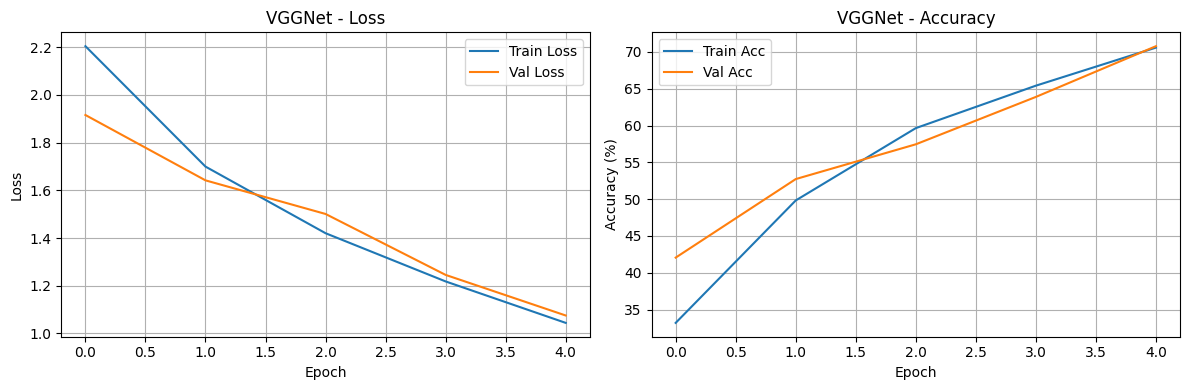


Part 2: Testing Network in Network
NiN Parameters: 1,620,308

Epoch 1/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 24.36it/s]


Train Loss: 2.5049, Train Acc: 36.38%
Val Loss: 2.1772, Val Acc: 42.76%

Epoch 2/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 23.95it/s]


Train Loss: 1.9879, Train Acc: 57.15%
Val Loss: 1.8190, Val Acc: 56.89%

Epoch 3/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 24.12it/s]


Train Loss: 1.6067, Train Acc: 67.00%
Val Loss: 1.4940, Val Acc: 66.79%

Epoch 4/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 24.20it/s]


Train Loss: 1.3010, Train Acc: 76.42%
Val Loss: 1.1186, Val Acc: 78.48%

Epoch 5/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 24.66it/s]


Train Loss: 1.0447, Train Acc: 82.31%
Val Loss: 0.9031, Val Acc: 85.83%


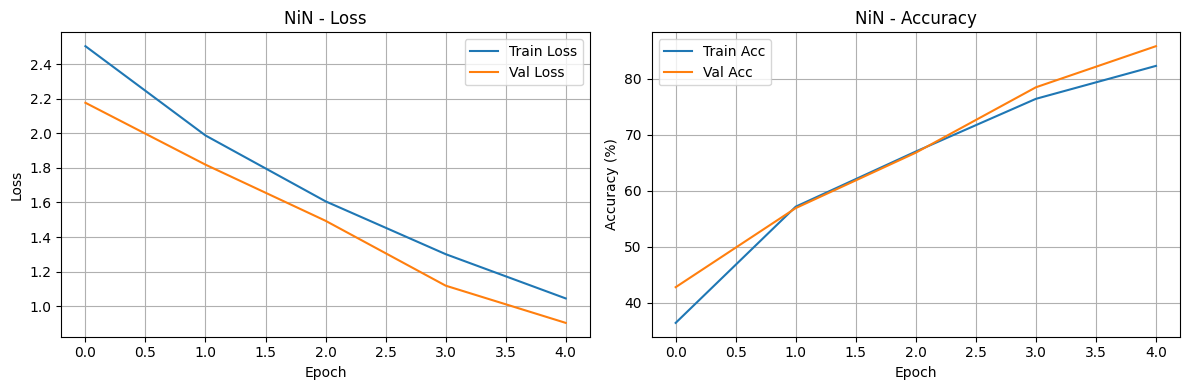


Part 3: Testing Inception Module
GoogLeNet Parameters: 545,074

Epoch 1/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.39it/s]


Train Loss: 2.0193, Train Acc: 39.60%
Val Loss: 1.7906, Val Acc: 47.03%

Epoch 2/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.10it/s]


Train Loss: 1.4299, Train Acc: 58.83%
Val Loss: 1.4955, Val Acc: 54.97%

Epoch 3/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.38it/s]


Train Loss: 1.1274, Train Acc: 67.49%
Val Loss: 1.1992, Val Acc: 65.19%

Epoch 4/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.73it/s]


Train Loss: 0.9233, Train Acc: 74.01%
Val Loss: 1.1749, Val Acc: 64.87%

Epoch 5/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 26.15it/s]


Train Loss: 0.7962, Train Acc: 77.66%
Val Loss: 0.9584, Val Acc: 72.08%


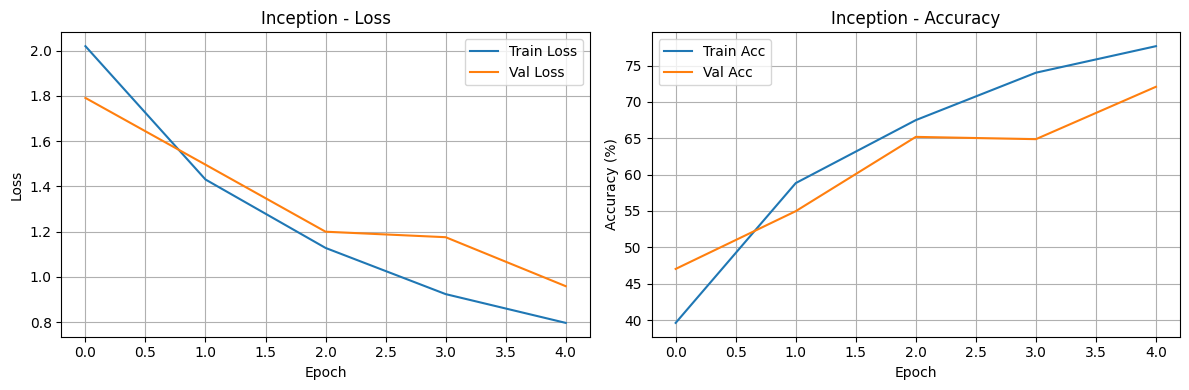


Part 4: Testing ResNet
ResNet18 Parameters: 11,185,746

Epoch 1/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.98it/s]


Train Loss: 2.1402, Train Acc: 34.41%
Val Loss: 1.8336, Val Acc: 43.00%

Epoch 2/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.69it/s]


Train Loss: 1.3891, Train Acc: 57.52%
Val Loss: 1.8876, Val Acc: 49.27%

Epoch 3/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.71it/s]


Train Loss: 0.9956, Train Acc: 70.34%
Val Loss: 1.1129, Val Acc: 68.16%

Epoch 4/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.76it/s]


Train Loss: 0.7523, Train Acc: 77.62%
Val Loss: 1.1749, Val Acc: 66.62%

Epoch 5/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.92it/s]


Train Loss: 0.5808, Train Acc: 82.81%
Val Loss: 0.7834, Val Acc: 76.49%


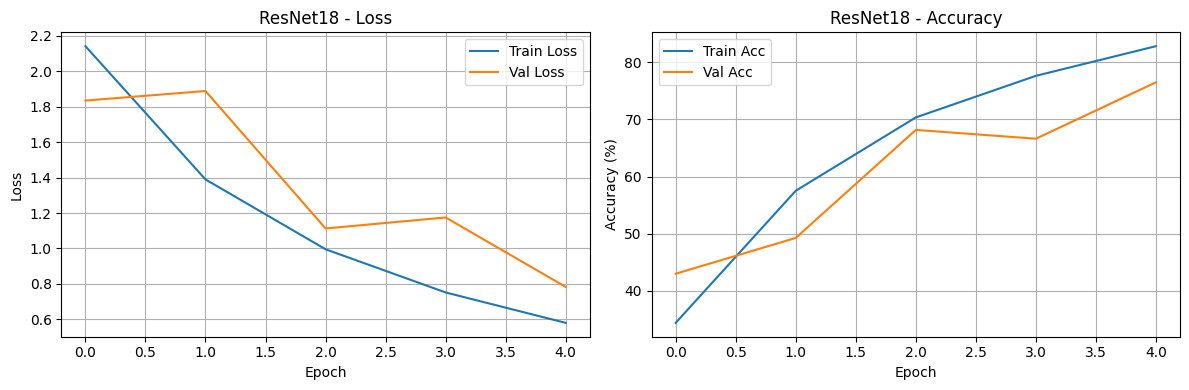


Part 5: Testing Transfer Learning

Testing Feature Extraction (frozen backbone)...

Epoch 1/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.66it/s]


Train Loss: 1.6956, Train Acc: 57.03%
Val Loss: 1.1794, Val Acc: 69.87%

Epoch 2/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.63it/s]


Train Loss: 1.4449, Train Acc: 68.03%
Val Loss: 0.9435, Val Acc: 77.22%

Epoch 3/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.17it/s]


Train Loss: 1.2307, Train Acc: 73.77%
Val Loss: 0.9688, Val Acc: 76.35%

Epoch 4/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.61it/s]


Train Loss: 1.1425, Train Acc: 77.18%
Val Loss: 0.9740, Val Acc: 78.83%

Epoch 5/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.21it/s]


Train Loss: 1.0820, Train Acc: 77.91%
Val Loss: 0.9121, Val Acc: 80.09%


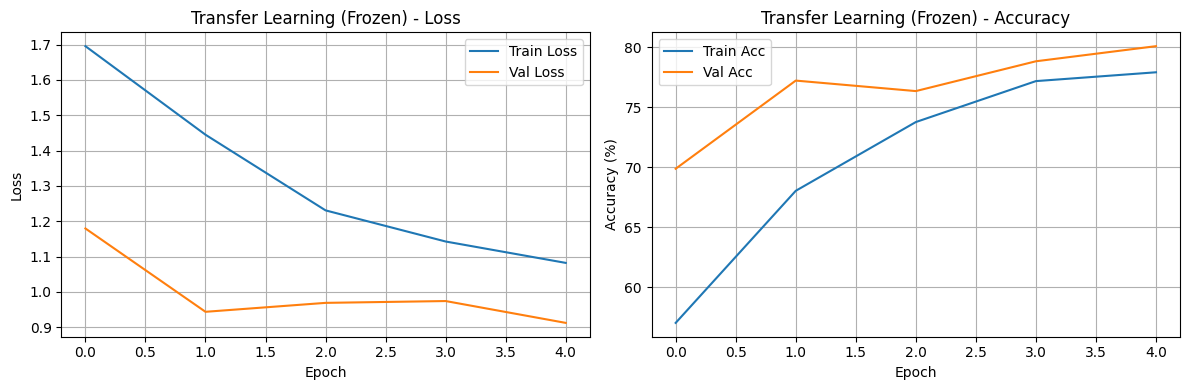


Testing Fine-tuning (trainable backbone)...

Epoch 1/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.52it/s]


Train Loss: 1.7647, Train Acc: 54.25%
Val Loss: 1.0731, Val Acc: 71.66%

Epoch 2/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.68it/s]


Train Loss: 1.4312, Train Acc: 67.90%
Val Loss: 0.9853, Val Acc: 76.24%

Epoch 3/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.50it/s]


Train Loss: 1.2075, Train Acc: 73.56%
Val Loss: 0.9902, Val Acc: 74.60%

Epoch 4/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.12it/s]


Train Loss: 1.1700, Train Acc: 75.29%
Val Loss: 0.9606, Val Acc: 78.66%

Epoch 5/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.21it/s]


Train Loss: 1.1098, Train Acc: 77.98%
Val Loss: 0.9215, Val Acc: 79.88%


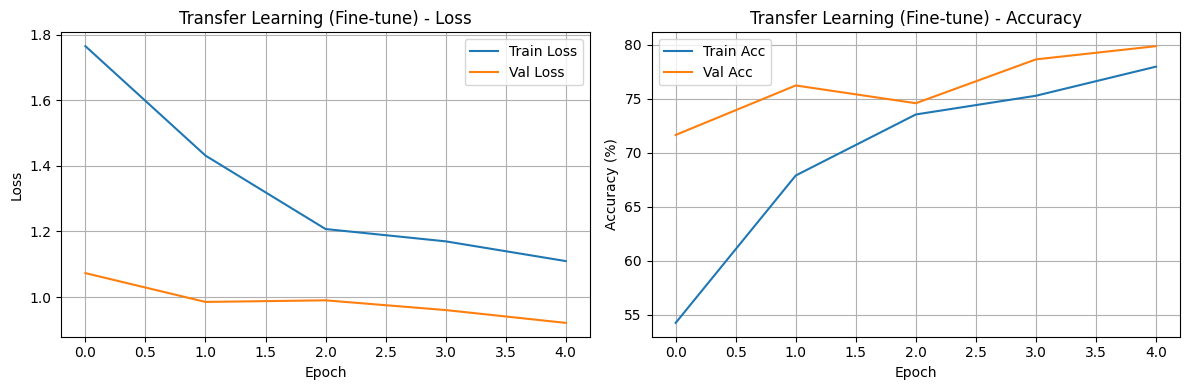


RESULTS SUMMARY
VGGNet              : 70.78%
NiN                 : 85.83%
Inception           : 72.08%
ResNet18            : 76.49%
Transfer_Frozen     : 80.09%
Transfer_Finetune   : 79.88%

Best Model: NiN with 85.83% validation accuracy

Keep improving! Current best: 85.83% (Target: 94% for bonus)

Assignment Complete!
Remember to submit: yourcomputingID_assignment_2.py


In [28]:
##  New block for assingment after data pull/transform section  ##

# ============================================================================
# Part 1: VGG-Style Blocks (15 points)
# ============================================================================


class ConvBNReLU(nn.Sequential):
    """
    The atomic unit of modern CNNs. This replaced Conv→ReLU after 2015.
    This is used EVERYWHERE - VGG, ResNet,
    MobileNet, EfficientNet. It's not just a pattern, it's THE pattern.
    """
    def __init__(self, c_in, c_out, kernel_size=3, stride=1, padding=1):
        super().__init__(
            # Key insight: bias=False because BN (batchnorm) learns bias
            # No forward method needed since the convolution2d to batchnorm to ReLU does it itself.
            nn.Conv2d(c_in, c_out, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True)  # inplace saves memory
        )


class VGGBlock(nn.Module):
    """
    TODO (5 pts): Implement a VGG-style block.

    VGG Design Philosophy: Use only 3x3 convolutions stacked for depth

    Architecture for this block:
    - Stack 'num_convs' 3x3 convolutions
    - Each conv: Conv2d -> BatchNorm2d -> ReLU
    - After all convs: MaxPool2d(2, 2) for spatial downsampling

    Implementation hints:
    1. Use a loop to create 'num_convs' conv layers
    2. First conv: in_channels -> out_channels
    3. Remaining convs: out_channels -> out_channels
    4. Use padding=1 to preserve spatial dimensions through convs
    5. Store all layers in nn.Sequential

    Why this design?
    - Two 3x3 convs = same receptive field as one 5x5
    - But with fewer parameters and more nonlinearity
    - Example: 2*(3*3*C*C) = 18C² vs 25C² for 5x5
    """
    def __init__(self, in_channels, out_channels, num_convs=2):
        super(VGGBlock, self).__init__()
        
        layers = []
        for i in range(num_convs):
            in_channels = in_channels if i == 0 else out_channels
            layers.append(ConvBNReLU(in_channels, out_channels, kernel_size=3, padding = 1))
        self.convs = nn.Sequential(*layers)
        self.block = nn.MaxPool2d(kernel_size = 2, stride = 2)

        #! TODO: Create layers list
        #! TODO: Loop through num_convs to add conv layers
        #! TODO: Add MaxPool2d at the end
        #! TODO: Combine into self.block = nn.Sequential(*layers)
        pass
        
    def forward(self, x):
        return self.block(self.convs(x))
    
        # TODO: Pass input through self.block
        pass


class VGGNet(nn.Module):
    """
    TODO (10 pts): Build a simplified VGG-style network.

    Architecture:
    1. Initial conv: 3 -> 64 channels (no pooling yet)
       - Conv2d(3, 64, 3, padding=1) -> BN -> ReLU
    2. VGGBlock: 64 -> 128 channels (doubles channels, halves spatial)
    3. VGGBlock: 128 -> 256 channels (doubles channels, halves spatial)
    4. Global Average Pooling: Reduces any spatial size to 1x1
    5. Classifier: Linear(256, num_classes)

    Design principles:
    - Double channels when halving spatial dimensions
    - This keeps computation roughly constant per layer
    - GAP instead of FC layers reduces parameters dramatically

    Expected parameter count: ~1.2M (vs original VGG-16's 138M!)
    """
    def __init__(self, num_classes=18):
        super(VGGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)  # inplace saves memory
        )
        self.block = nn.Sequential(
            VGGBlock(in_channels=64, out_channels=128, num_convs=1),    # VGGBlock 1: 150×150 → 75×75
            VGGBlock(in_channels=128, out_channels=256, num_convs=2),   # VGGBlock 2: 75×75 → 37×37 (floor of 75/2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Linear(256, num_classes)
        
        # TODO: Create initial conv layer (3->64)
        # TODO: Create two VGGBlocks (64->128, 128->256)
        # TODO: Store conv layers in self.features = nn.Sequential(...)
        # TODO: Add self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # TODO: Add self.classifier = nn.Linear(256, num_classes)
        pass

    def forward(self, x):
        x = self.features(x)           # (batch, 64, 150, 150)
        x = self.block(x)              # (batch, 256, 37, 37)
        x = self.avgpool(x)            # (batch, 256, 1, 1)
        x = x.flatten(start_dim = 1)     # (batch, 256) - preserve batch dimension
        return self.classifier(x)      # (batch, num_classes)
        
        # TODO: Pass through features
        # TODO: Apply global average pooling
        # TODO: Flatten to (batch_size, 256)
        # TODO: Pass through classifier
        pass


# ============================================================================
# Part 2: Network in Network (NiN) with GAP (15 points)
# ============================================================================

class NiNBlock(nn.Module):
    """
    TODO (5 pts): Implement a Network-in-Network block.

    NiN Innovation: Add 1x1 convolutions for cross-channel mixing
    Think of 1x1 convs as "mini MLPs" applied at each spatial location

    Architecture:
    1. Spatial conv (specified kernel_size): Extract spatial features
    2. First 1x1 conv: Mix channels, add nonlinearity
    3. Second 1x1 conv: Further mix channels, add nonlinearity

    Each conv layer: Conv2d -> BatchNorm2d -> ReLU

    Implementation:
    - All three convolutions use the same output channels
    - This creates a "micronetwork" within the network

    Parameters comparison (for 3x3 kernel):
    - Standard conv only: 9 * in_ch * out_ch
    - NiN (3 layers): 9 * in_ch * out_ch + 2 * out_ch * out_ch
    - More parameters but much more expressive power
    
    Network in Network: 1×1 convs as channel mixers

    THREE INNOVATIONS (cover each):
    1. 1×1 convs = per-pixel MLPs (cheap non-linearity)
    2. No spatial mixing in 1×1 (only channel mixing)
    3. Enables Global Average Pooling (coming next)

    HISTORICAL NOTE: This enabled GoogLeNet's inception modules
    """
    
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(NiNBlock, self).__init__()
        self.conv_block = nn.Sequential(
            ConvBNReLU(in_channels, out_channels, kernel_size=3, padding=1),
            ConvBNReLU(out_channels, out_channels, kernel_size=1),
            ConvBNReLU(out_channels, out_channels, kernel_size=1),
        )
        
        # TODO: Create main spatial convolution
        # TODO: Add first 1x1 conv for channel mixing
        # TODO: Add second 1x1 conv for more mixing
        # TODO: Each conv needs BN and ReLU
        # TODO: Combine in self.conv_block = nn.Sequential(...)
        pass

    def forward(self, x):
        return self.conv_block(x)
    
        # TODO: Pass through conv_block
        pass


class NiN(nn.Module):
    """
    TODO (10 pts): Build a Network-in-Network model.

    Architecture (follows original paper):
    1. NiNBlock: 3 -> 96, kernel=11, stride=4
       - Large kernel for initial feature extraction
    2. MaxPool2d(3, 2): Spatial reduction
    3. NiNBlock: 96 -> 256, kernel=5, padding=2
       - Medium kernel for mid-level features
    4. MaxPool2d(3, 2): Spatial reduction
    5. NiNBlock: 256 -> 384, kernel=3, padding=1
       - Small kernel for high-level features
    6. MaxPool2d(3, 2): Spatial reduction
    7. NiNBlock: 384 -> num_classes, kernel=3, padding=1
       - Output channels = num_classes (KEY INNOVATION!)
    8. Global Average Pooling: Direct to predictions

    Key insight: No FC layers needed!
    - Last NiN block outputs num_classes channels
    - GAP averages each channel -> one prediction per class
    - Saves millions of parameters vs traditional FC layers

    Expected parameters: ~1M (very efficient!)
    """
    def __init__(self, num_classes=18):
        super(NiN, self).__init__()
        self.features = nn.Sequential(
            NiNBlock(3, 96, kernel_size = 11, stride=4),
            nn.MaxPool2d((3, 2)),
            NiNBlock(96, 256, kernel_size = 5, padding=2),
            nn.MaxPool2d((3, 2)),
            NiNBlock(256, 384, kernel_size = 3, padding=1),
            nn.MaxPool2d((3, 2)),            
            NiNBlock(384, num_classes, kernel_size = 3, padding=1),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # TODO: Build the architecture as described
        # TODO: Store all layers in self.features = nn.Sequential(...)
        # TODO: Note: GAP should be part of features
        pass

    def forward(self, x):
        return self.features(x).flatten(start_dim = 1)
    
        # TODO: Pass through features
        # TODO: Flatten to (batch_size, num_classes)
        # Note: No classifier needed - NiN directly outputs class scores!
        pass


# ============================================================================
# Part 3: Inception Module (15 points)
# ============================================================================

class InceptionBlock(nn.Module):
    """
    TODO (15 pts): Implement an Inception module.

    The Inception Hypothesis: Let the network choose the right filter size!
    Process the input at multiple scales in parallel, then concatenate.

    Four parallel branches:
    1. 1x1 branch: Captures point-wise features
       - Conv2d(in_channels, ch1x1, kernel=1) -> BN -> ReLU

    2. 3x3 branch: Captures small spatial patterns
       - Conv2d(in_channels, ch3x3_reduce, kernel=1) -> BN -> ReLU (bottleneck)
       - Conv2d(ch3x3_reduce, ch3x3, kernel=3, padding=1) -> BN -> ReLU

    3. 5x5 branch: Captures larger spatial patterns
       - Conv2d(in_channels, ch5x5_reduce, kernel=1) -> BN -> ReLU (bottleneck)
       - Conv2d(ch5x5_reduce, ch5x5, kernel=5, padding=2) -> BN -> ReLU

    4. Pool branch: Captures downsampled features
       - MaxPool2d(kernel=3, stride=1, padding=1) (maintains size!)
       - Conv2d(in_channels, pool_proj, kernel=1) -> BN -> ReLU

    Critical: Use 1x1 "bottleneck" convolutions before expensive 3x3 and 5x5!
    This reduces computation by ~10x while maintaining expressiveness.

    Example computation savings:
    - Direct 5x5: 5*5*256*128 = 819,200 operations
    - With 1x1 bottleneck (256->32->128): 1*1*256*32 + 5*5*32*128 = 110,592
    - Reduction: 7.4x fewer operations!

    Output channels = ch1x1 + ch3x3 + ch5x5 + pool_proj
    """
    def __init__(self, in_channels, ch1x1, ch3x3_reduce, ch3x3, ch5x5_reduce, ch5x5, pool_proj):
        super(InceptionBlock, self).__init__()
        self.branch1 = ConvBNReLU(in_channels, ch1x1, kernel_size = 1)
        
        # TODO: Implement Branch 1 (1x1 conv)
        # self.branch1 = nn.Sequential(...)

        self.branch2 = nn.Sequential(
            ConvBNReLU(in_channels, ch3x3_reduce, kernel_size = 1), # these reduces are getting split before sent to the block.
            ConvBNReLU(ch3x3_reduce, ch3x3, kernel_size = 3, padding = 1)
        )
        
        # TODO: Implement Branch 2 (1x1 -> 3x3)
        # self.branch2 = nn.Sequential(...)
        
        self.branch3 = nn.Sequential(
            ConvBNReLU(in_channels, ch5x5_reduce, kernel_size = 1), # these reduces are getting split before sent to the block.
            ConvBNReLU(ch5x5_reduce, ch5x5, kernel_size = 5, padding = 2)
        )

        # TODO: Implement Branch 3 (1x1 -> 5x5)
        # self.branch3 = nn.Sequential(...)
        
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1),
            ConvBNReLU(in_channels, pool_proj, kernel_size = 1)
        )

        # TODO: Implement Branch 4 (pool -> 1x1)
        # self.branch4 = nn.Sequential(...)
        
        pass

    def forward(self, x):
        return torch.cat([
            self.branch1(x),
            self.branch2(x),
            self.branch3(x),
            self.branch4(x)
        ], dim = 1)
        
        # TODO: Pass input through all 4 branches
        # TODO: Concatenate outputs along channel dimension (dim=1)
        # Hint: outputs = [branch1_out, branch2_out, branch3_out, branch4_out]
        # return torch.cat(outputs, 1)
        pass


class SimpleGoogLeNet(nn.Module):
    """
    Simplified GoogLeNet with Inception modules.
    This is provided to show how Inception blocks are used.
    Study this to understand the channel calculations!
    """
    def __init__(self, num_classes=18):
        super(SimpleGoogLeNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Inception3a: input=64, output=256 (64+128+32+32)
        self.inception3a = InceptionBlock(64, 64, 96, 128, 16, 32, 32)
        # Inception3b: input=256, output=480 (128+192+96+64)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(480, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


# ============================================================================
# Part 4: ResNet Blocks (15 points)
# ============================================================================

class BasicBlock(nn.Module):
    """
    TODO (7 pts): Implement a basic ResNet block with skip connection.

    The ResNet Revolution: Make the network learn residuals!
    Instead of learning H(x), learn F(x) = H(x) - x
    Then output = F(x) + x

    Architecture:
    Main path: Conv3x3 -> BN -> ReLU -> Conv3x3 -> BN
    Skip path: Identity or 1x1 projection
    Output: Add paths -> ReLU

    Implementation details:
    1. First conv may have stride for downsampling
    2. No bias in conv layers (BN handles bias)
    3. Skip connection needs projection if:
       - stride != 1 (spatial size changes)
       - in_channels != out_channels (channel size changes)
    4. Projection = Conv2d(1x1, stride) -> BN

    Why this works:
    - Identity is easy to learn (just set F(x) ≈ 0)
    - Gradients flow directly through skip connections
    - Enables training of very deep networks (100+ layers)

    Memory consideration: Skip connections double memory during training
    (need to store both paths for backprop)
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = ConvBNReLU(in_channels, out_channels, kernel_size = 3, stride = stride) # bias preset to False, padding set to 1
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)            
        )
        
        # TODO: Create main path layers
        # self.conv1 = nn.Conv2d(..., bias=False)
        # self.bn1 = nn.BatchNorm2d(...)
        # self.relu = nn.ReLU(inplace=True)
        # self.conv2 = nn.Conv2d(..., bias=False)
        # self.bn2 = nn.BatchNorm2d(...)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride = stride, bias=False),
                nn.BatchNorm2d(out_channels)                     
            )
            
        
        # TODO: Create shortcut path
        # self.shortcut = nn.Sequential()  # Identity by default
        # if stride != 1 or in_channels != out_channels:
        #     self.shortcut = nn.Sequential(
        #         nn.Conv2d(..., kernel_size=1, stride=stride, bias=False),
        #         nn.BatchNorm2d(...)
        #     )
        pass

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv2(self.conv1(x))
        out = out + identity
        return F.relu(out, inplace = True)
    
        # TODO: Save input for skip connection
        # TODO: Pass through main path (conv1->bn1->relu->conv2->bn2)
        # TODO: Add skip connection
        # TODO: Apply final ReLU
        pass


class ResNet18(nn.Module):
    """
    TODO (8 pts): Build ResNet-18 architecture.

    ResNet-18 Structure:
    - Conv1: 7x7, stride=2 (reduces to 1/2 size)
    - MaxPool: 3x3, stride=2 (reduces to 1/4 size)
    - Layer1: 2 blocks of 64 channels (no downsampling)
    - Layer2: 2 blocks of 128 channels (first block downsamples)
    - Layer3: 2 blocks of 256 channels (first block downsamples)
    - Layer4: 2 blocks of 512 channels (first block downsamples)
    - Global Average Pooling
    - FC: 512 -> num_classes

    Implementation hint: Create a helper function!
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        - First block uses given stride (may downsample)
        - Remaining blocks use stride=1
        - Return nn.Sequential(*blocks)

    Why "18"? Count the layers with learnable parameters:
    1 (conv1) + 2*2 (layer1) + 2*2 (layer2) + 2*2 (layer3) + 2*2 (layer4) + 1 (fc) = 18

    Expected parameters: ~11M
    Despite depth, trains easily due to skip connections!
    """

    def __init__(self, num_classes=18):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Sequential(
            ConvBNReLU(3, 64, kernel_size = 7, stride = 2),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        # TODO: Build conv1 (initial feature extraction)
        # self.conv1 = nn.Sequential(...)

        self.layer1 = self._make_layer(64, 64, 2, stride = 1)
        self.layer2 = self._make_layer(64, 128, 2, stride = 2)
        self.layer3 = self._make_layer(128, 256, 2, stride = 2)
        self.layer4 = self._make_layer(256, 512, 2, stride = 2)        

        # TODO: Build residual layers
        # self.layer1 = self._make_layer(64, 64, 2, stride=1)
        # self.layer2 = self._make_layer(64, 128, 2, stride=2)
        # etc.

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        # TODO: Add GAP and classifier
        # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc = nn.Linear(512, num_classes)
        pass

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        blocks = []
        for block in range(num_blocks): 
            if block == 0:
                blocks.append(BasicBlock(in_channels, out_channels, stride = stride))
            else:
                blocks.append(BasicBlock(out_channels, out_channels, stride = 1))

        return nn.Sequential(*blocks)

        # TODO: Create list of blocks
        # First block handles stride and channel change
        # Remaining blocks maintain dimensions
        pass

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x).flatten(start_dim = 1)
        return self.fc(x)
        # TODO: Pass through all layers in sequence
        pass


# ============================================================================
# Part 5: Transfer Learning (20 points)
# ============================================================================

def get_pretrained_model(model_name='resnet18', num_classes=18, feature_extract=True):
    """
    TODO (20 pts): Implement transfer learning with pretrained models.

    Transfer Learning: Use features learned on ImageNet for our task!

    Two strategies:
    1. Feature Extraction (feature_extract=True):
       - Freeze all conv layers (no gradient updates)
       - Only train the new classifier
       - Fast training, good for small datasets
       - Use when: limited data, similar domain

    2. Fine-tuning (feature_extract=False):
       - Initialize with pretrained weights
       - Allow all layers to update
       - Slower training but can achieve higher accuracy
       - Use when: more data, different domain

    Implementation steps for each model type:

    ResNet18:
    1. Load: models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    2. Freeze: Loop through parameters, set requires_grad=False
    3. Replace: model.fc = nn.Linear(model.fc.in_features, num_classes)

    VGG16:
    1. Load: models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    2. Freeze: Focus on model.features (conv layers)
    3. Replace: model.classifier[6] (last linear layer)

    MobileNetV2:
    1. Load: models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
    2. Freeze: All parameters
    3. Replace: model.classifier[1] (last linear layer)

    Tips:
    - Always replace the final layer to match num_classes
    - When fine-tuning, use lower learning rate (1e-4 or 1e-5)
    - Consider unfreezing only last few layers for better results

    Expected accuracy:
    - Feature extraction: 85-90% in 5 epochs
    - Fine-tuning: 90-95% in 10 epochs
    """
    
    if model_name == "resnet18":
        weights = models.ResNet18_Weights.DEFAULT
        model = models.resnet18(weights = weights)
    
        if feature_extract:
            for param in model.parameters(): # Loop through all model parameters
                param.requires_grad = False # Set requires_grad to False to prevent updating during training

        model.fc = nn.Linear(model.fc.in_features, num_classes)  # 512 in_features for ResNet-18

    elif model_name == "vgg16":
        weights = models.VGG16_Weights.DEFAULT
        model = models.vgg16(weights=weights)

        if feature_extract:
            for param in model.features.parameters():
                param.requires_grad = False
        else:
            # Fine-tuning: freeze conv layers, unfreeze classifier
            for param in model.features.parameters():
                param.requires_grad = False
            # Keep classifier unfrozen (it's already unfrozen by default)

        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_features, num_classes)

    elif model_name == "mobilenet_v2":
        weights = models.MobileNet_V2_Weights.DEFAULT
        model = models.mobilenet_v2(weights = weights)
        
        if feature_extract:  
            for param in model.parameters():
                param.requires_grad = False 
        else:
            for param in model.parameters():
                param.requires_grad = False 
            # Unfreeze ONLY the last inverted residual blocks (15-18) and classifier
            # This is the correct way to unfreeze specific layers by name
            for name, param in model.named_parameters():
                if 'features.15' in name or 'features.16' in name or 'features.17' in name or 'features.18' in name or 'classifier' in name:
                    param.requires_grad = True

        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, num_classes)

    else:
        raise ValueError("Mode must be 'resnet18', 'vgg16', or 'mobilenet_v2'.")

    return model

    
    # TODO: Check model_name and load appropriate pretrained model
    # TODO: Implement freezing logic based on feature_extract flag
    # TODO: Replace final classifier layer
    # TODO: Return the modified model
    # Don't forget error handling for unsupported model names!
    pass


# ============================================================================
# Training and Evaluation Functions (Provided - No modifications needed)
# ============================================================================

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train the model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    """Evaluate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    """
    Train and evaluate a model.

    Returns:
        Dictionary with training history
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        scheduler.step()

    return history


def plot_training_history(history, title="Training History"):
    """Plot training and validation loss/accuracy."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_acc'], label='Train Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{title} - Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


# ============================================================================
# Main Execution - Test Your Implementations
# ============================================================================

if __name__ == "__main__":
    print("=" * 60)
    print("Testing your CNN implementations on UVA Landmarks Dataset")
    print("=" * 60)

    # Test each architecture with fewer epochs for quick validation
    test_epochs = 5  # Increase to 20-30 for better results

    # Dictionary to store results
    results = {}

    # Part 1: Test VGGNet
    print("\n" + "="*60)
    print("Part 1: Testing VGGNet")
    print("="*60)
    try:
        vgg_model = VGGNet(num_classes=num_classes)
        print(f"VGGNet Parameters: {sum(p.numel() for p in vgg_model.parameters()):,}")
        vgg_history = train_model(vgg_model, train_loader, val_loader, num_epochs=test_epochs)
        results['VGGNet'] = vgg_history['val_acc'][-1]
        plot_training_history(vgg_history, "VGGNet")
    except Exception as e:
        print(f"Error in VGGNet: {e}")
        results['VGGNet'] = 0

    # Part 2: Test NiN
    print("\n" + "="*60)
    print("Part 2: Testing Network in Network")
    print("="*60)
    try:
        nin_model = NiN(num_classes=num_classes)
        print(f"NiN Parameters: {sum(p.numel() for p in nin_model.parameters()):,}")
        nin_history = train_model(nin_model, train_loader, val_loader, num_epochs=test_epochs)
        results['NiN'] = nin_history['val_acc'][-1]
        plot_training_history(nin_history, "NiN")
    except Exception as e:
        print(f"Error in NiN: {e}")
        results['NiN'] = 0

    # Part 3: Test Inception
    print("\n" + "="*60)
    print("Part 3: Testing Inception Module")
    print("="*60)
    try:
        inception_model = SimpleGoogLeNet(num_classes=num_classes)
        print(f"GoogLeNet Parameters: {sum(p.numel() for p in inception_model.parameters()):,}")
        inception_history = train_model(inception_model, train_loader, val_loader, num_epochs=test_epochs)
        results['Inception'] = inception_history['val_acc'][-1]
        plot_training_history(inception_history, "Inception")
    except Exception as e:
        print(f"Error in Inception: {e}")
        results['Inception'] = 0

    # Part 4: Test ResNet
    print("\n" + "="*60)
    print("Part 4: Testing ResNet")
    print("="*60)
    try:
        resnet_model = ResNet18(num_classes=num_classes)
        print(f"ResNet18 Parameters: {sum(p.numel() for p in resnet_model.parameters()):,}")
        resnet_history = train_model(resnet_model, train_loader, val_loader, num_epochs=test_epochs)
        results['ResNet18'] = resnet_history['val_acc'][-1]
        plot_training_history(resnet_history, "ResNet18")
    except Exception as e:
        print(f"Error in ResNet: {e}")
        results['ResNet18'] = 0

    # Part 5: Test Transfer Learning
    print("\n" + "="*60)
    print("Part 5: Testing Transfer Learning")
    print("="*60)

    # Test feature extraction
    try:
        print("\nTesting Feature Extraction (frozen backbone)...")
        pretrained_frozen = get_pretrained_model('vgg16', num_classes=num_classes, feature_extract=True)
        frozen_history = train_model(pretrained_frozen, train_loader, val_loader, num_epochs=test_epochs)
        results['Transfer_Frozen'] = frozen_history['val_acc'][-1]
        plot_training_history(frozen_history, "Transfer Learning (Frozen)")
    except Exception as e:
        print(f"Error in Transfer Learning (Frozen): {e}")
        results['Transfer_Frozen'] = 0

    # Test fine-tuning
    try:
        print("\nTesting Fine-tuning (trainable backbone)...")
        pretrained_finetune = get_pretrained_model('vgg16', num_classes=num_classes, feature_extract=False)
        finetune_history = train_model(pretrained_finetune, train_loader, val_loader,
                                      num_epochs=test_epochs, lr=0.001)
        results['Transfer_Finetune'] = finetune_history['val_acc'][-1]
        plot_training_history(finetune_history, "Transfer Learning (Fine-tune)")
    except Exception as e:
        print(f"Error in Transfer Learning (Fine-tune): {e}")
        results['Transfer_Finetune'] = 0

    # Print summary of results
    print("\n" + "="*60)
    print("RESULTS SUMMARY")
    print("="*60)
    for model_name, accuracy in results.items():
        print(f"{model_name:20s}: {accuracy:.2f}%")

    best_model = max(results, key=results.get)
    best_accuracy = results[best_model]
    print(f"\nBest Model: {best_model} with {best_accuracy:.2f}% validation accuracy")

    if best_accuracy > 94:
        print("\n🎉 BONUS ACHIEVED! Accuracy > 94%")
    else:
        print(f"\nKeep improving! Current best: {best_accuracy:.2f}% (Target: 94% for bonus)")

    print("\n" + "="*60)
    print("Assignment Complete!")
    print("Remember to submit: yourcomputingID_assignment_2.py")
    print("="*60)

Training samples: 11428
Validation samples: 2858
Testing your CNN implementations on UVA Landmarks Dataset

Part 5: Testing Transfer Learning

Testing Feature Extraction (frozen backbone)...

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.64it/s]


Train Loss: 1.6884, Train Acc: 60.67%
Val Loss: 1.2466, Val Acc: 77.54%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.38it/s]


Train Loss: 1.3726, Train Acc: 72.02%
Val Loss: 1.1485, Val Acc: 81.35%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.51it/s]


Train Loss: 1.2771, Train Acc: 76.03%
Val Loss: 1.1166, Val Acc: 82.05%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.61it/s]


Train Loss: 1.2173, Train Acc: 78.21%
Val Loss: 1.0913, Val Acc: 83.28%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.81it/s]


Train Loss: 1.1647, Train Acc: 80.20%
Val Loss: 1.0544, Val Acc: 85.44%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.41it/s]


Train Loss: 1.1410, Train Acc: 81.13%
Val Loss: 1.0363, Val Acc: 85.51%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.57it/s]


Train Loss: 1.1065, Train Acc: 82.24%
Val Loss: 1.0318, Val Acc: 85.97%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.35it/s]


Train Loss: 1.0755, Train Acc: 83.82%
Val Loss: 1.0215, Val Acc: 86.07%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.57it/s]


Train Loss: 1.0524, Train Acc: 84.71%
Val Loss: 1.0116, Val Acc: 86.91%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.69it/s]


Train Loss: 1.0361, Train Acc: 85.29%
Val Loss: 1.0066, Val Acc: 86.74%


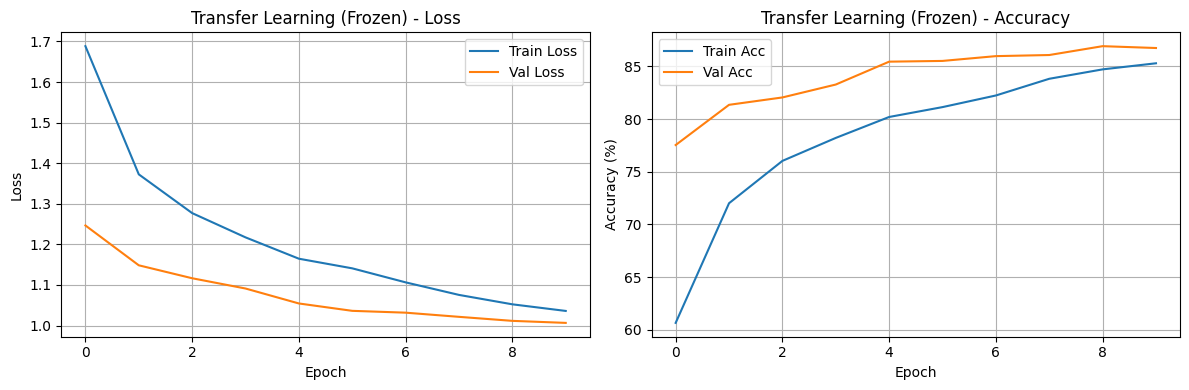


Testing Fine-tuning (trainable backbone)...

Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.76it/s]


Train Loss: 1.3693, Train Acc: 73.05%
Val Loss: 0.9690, Val Acc: 88.10%

Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 24.16it/s]


Train Loss: 0.9423, Train Acc: 89.47%
Val Loss: 0.8945, Val Acc: 90.45%

Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.61it/s]


Train Loss: 0.8194, Train Acc: 93.70%
Val Loss: 0.8407, Val Acc: 92.09%

Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 24.41it/s]


Train Loss: 0.7650, Train Acc: 95.76%
Val Loss: 0.8229, Val Acc: 92.55%

Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 24.24it/s]


Train Loss: 0.7033, Train Acc: 97.53%
Val Loss: 0.8028, Val Acc: 93.46%

Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 24.93it/s]


Train Loss: 0.6791, Train Acc: 98.16%
Val Loss: 0.7908, Val Acc: 93.32%

Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 24.64it/s]


Train Loss: 0.6582, Train Acc: 98.77%
Val Loss: 0.7699, Val Acc: 94.09%

Epoch 8/10
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 24.72it/s]


Train Loss: 0.6388, Train Acc: 99.24%
Val Loss: 0.7681, Val Acc: 94.12%

Epoch 9/10
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.09it/s]


Train Loss: 0.6298, Train Acc: 99.43%
Val Loss: 0.7657, Val Acc: 94.19%

Epoch 10/10
------------------------------


Evaluating: 100%|██████████| 90/90 [00:03<00:00, 25.11it/s]


Train Loss: 0.6260, Train Acc: 99.54%
Val Loss: 0.7608, Val Acc: 94.37%


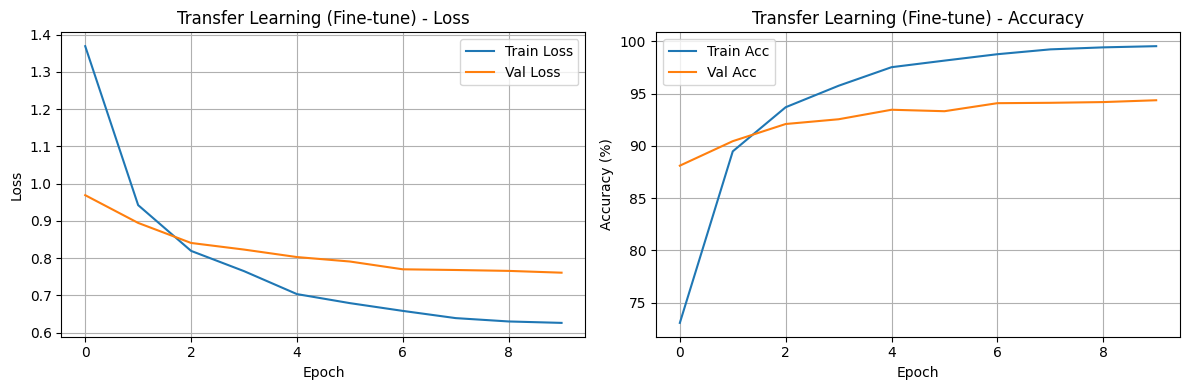


RESULTS SUMMARY
Transfer_Frozen     : 86.74%
Transfer_Finetune   : 94.37%

Best Model: Transfer_Finetune with 94.37% validation accuracy

🎉 BONUS ACHIEVED! Accuracy > 94%

Assignment Complete!
Remember to submit: yourcomputingID_assignment_2.py


In [24]:
##  Attempting to get >94% validation accuracy  ##
# Using weight decay in Adam, label_smoothing in criterion. Increased number of epochs and changed learning rate. CosineAnnealingLR for scheduler instead of steplr.
# Unfreezing only the last few layers for mobilenet_v2, optimized this one to be above 94%
# For train_model - added changing learning rate for backbone vs classifier. 
# Data changes:
    # color changes, blur, ratoation and vertical flip (reduced the amount of change in each from first testing to have better learning within 10 epochs.

# Data transforms EDITTED
train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.2),  # NEW: Add vertical flip for landmarks
    transforms.RandomRotation(degrees=10),  # NEW: Rotation augmentation
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.05),  # NEW: Color variations
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # NEW: Slight translations
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),  # NEW: Slight blur for robustness
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
full_dataset = datasets.ImageFolder(data_dir)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Apply transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


def get_pretrained_model(model_name='resnet18', num_classes=18, feature_extract=True):
    """
    TODO (20 pts): Implement transfer learning with pretrained models.

    Transfer Learning: Use features learned on ImageNet for our task!

    Two strategies:
    1. Feature Extraction (feature_extract=True):
       - Freeze all conv layers (no gradient updates)
       - Only train the new classifier
       - Fast training, good for small datasets
       - Use when: limited data, similar domain

    2. Fine-tuning (feature_extract=False):
       - Initialize with pretrained weights
       - Allow all layers to update
       - Slower training but can achieve higher accuracy
       - Use when: more data, different domain

    Implementation steps for each model type:

    ResNet18:
    1. Load: models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    2. Freeze: Loop through parameters, set requires_grad=False
    3. Replace: model.fc = nn.Linear(model.fc.in_features, num_classes)

    VGG16:
    1. Load: models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    2. Freeze: Focus on model.features (conv layers)
    3. Replace: model.classifier[6] (last linear layer)

    MobileNetV2:
    1. Load: models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
    2. Freeze: All parameters
    3. Replace: model.classifier[1] (last linear layer)

    Tips:
    - Always replace the final layer to match num_classes
    - When fine-tuning, use lower learning rate (1e-4 or 1e-5)
    - Consider unfreezing only last few layers for better results

    Expected accuracy:
    - Feature extraction: 85-90% in 5 epochs
    - Fine-tuning: 90-95% in 10 epochs
    """
    
    if model_name == "resnet18":
        weights = models.ResNet18_Weights.DEFAULT
        model = models.resnet18(weights = weights)
    
        if feature_extract:
            for param in model.parameters(): # Loop through all model parameters
                param.requires_grad = False # Set requires_grad to False to prevent updating during training

        model.fc = nn.Linear(model.fc.in_features, num_classes)  # 512 in_features for ResNet-18

    elif model_name == "vgg16":
        weights = models.VGG16_Weights.DEFAULT
        model = models.vgg16(weights = weights)

        if feature_extract:
            for param in model.features.parameters(): # Loop through parameters in the features module (all conv layers)
                param.requires_grad = False # Prevent updating conv layers during training

        # VGG16 classifier: [0-2: first fc layers, 3-4: relu+dropout, 5: second fc, 6: final fc]
        num_features = model.classifier[6].in_features # Get the input features from the existing final layer (4096 in_features for VGG16)
        # model.classifier[6] = nn.Linear(num_features, num_classes)  # Replace classifier[6] with new Linear layer that outputs num_classes
        model.classifier = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    elif model_name == "mobilenet_v2":
        weights = models.MobileNet_V2_Weights.DEFAULT
        model = models.mobilenet_v2(weights = weights)
        
        if feature_extract:  
            for param in model.parameters():
                param.requires_grad = False 
        else:
            for param in model.parameters():
                param.requires_grad = False 
            # Unfreeze ONLY the last inverted residual blocks (15-18) and classifier
            # This is the correct way to unfreeze specific layers by name
            for name, param in model.named_parameters():
                if 'features.15' in name or 'features.16' in name or 'features.17' in name or 'features.18' in name or 'classifier' in name:
                    param.requires_grad = True

        num_features = model.classifier[1].in_features
        # model.classifier[1] = nn.Linear(num_features, num_classes)
        model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    else:
        raise ValueError("Mode must be 'resnet18', 'vgg16', or 'mobilenet_v2'.")

    return model

    
    # TODO: Check model_name and load appropriate pretrained model
    # TODO: Implement freezing logic based on feature_extract flag
    # TODO: Replace final classifier layer
    # TODO: Return the modified model
    # Don't forget error handling for unsupported model names!
    pass

# ============================================================================
# Training and Evaluation Functions (Provided - No modifications needed)
# ============================================================================

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train the model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    """Evaluate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.0001, feature_extract=True):
    """
    Train and evaluate a model.

    Returns:
        Dictionary with training history
    """
    model = model.to(device)
    
        # For fine-tuning, use differential learning rates
    if not feature_extract:
        backbone_params = []
        classifier_params = []
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                if 'classifier' in name:
                    classifier_params.append(param)
                else:
                    backbone_params.append(param)
        
        # Backbone gets 10x lower learning rate than classifier
        optimizer = optim.Adam([
            {'params': backbone_params, 'lr': lr * 0.1, 'weight_decay': 0.0001},
            {'params': classifier_params, 'lr': lr, 'weight_decay': 0.0001}
        ])
    else:
        # For frozen feature extraction, all trainable params are just the classifier
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    best_val_acc = 0
    patience = 10
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        scheduler.step()

    return history


def plot_training_history(history, title="Training History"):
    """Plot training and validation loss/accuracy."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['train_acc'], label='Train Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{title} - Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print("=" * 60)
    print("Testing your CNN implementations on UVA Landmarks Dataset")
    print("=" * 60)

    # Test each architecture with fewer epochs for quick validation
    test_epochs = 10  # Increase to 20-30 for better results

    # Dictionary to store results
    results = {}

    # Part 5: Test Transfer Learning
    print("\n" + "="*60)
    print("Part 5: Testing Transfer Learning")
    print("="*60)

    # Test feature extraction
    try:
        print("\nTesting Feature Extraction (frozen backbone)...")
        pretrained_frozen = get_pretrained_model('mobilenet_v2', num_classes=num_classes, feature_extract=True)
        frozen_history = train_model(pretrained_frozen, train_loader, val_loader, num_epochs=test_epochs, lr=.001, feature_extract=True )
        results['Transfer_Frozen'] = frozen_history['val_acc'][-1]
        plot_training_history(frozen_history, "Transfer Learning (Frozen)")
    except Exception as e:
        print(f"Error in Transfer Learning (Frozen): {e}")
        results['Transfer_Frozen'] = 0

    # Test fine-tuning
    try:
        print("\nTesting Fine-tuning (trainable backbone)...")
        pretrained_finetune = get_pretrained_model('mobilenet_v2', num_classes=num_classes, feature_extract=False)
        finetune_history = train_model(pretrained_finetune, train_loader, val_loader,
                                      num_epochs=test_epochs, lr=0.005,  feature_extract=False)
        results['Transfer_Finetune'] = finetune_history['val_acc'][-1]
        plot_training_history(finetune_history, "Transfer Learning (Fine-tune)")
    except Exception as e:
        print(f"Error in Transfer Learning (Fine-tune): {e}")
        results['Transfer_Finetune'] = 0

    # Print summary of results
    print("\n" + "="*60)
    print("RESULTS SUMMARY")
    print("="*60)
    for model_name, accuracy in results.items():
        print(f"{model_name:20s}: {accuracy:.2f}%")

    best_model = max(results, key=results.get)
    best_accuracy = results[best_model]
    print(f"\nBest Model: {best_model} with {best_accuracy:.2f}% validation accuracy")

    if best_accuracy > 94:
        print("\n🎉 BONUS ACHIEVED! Accuracy > 94%")
    else:
        print(f"\nKeep improving! Current best: {best_accuracy:.2f}% (Target: 94% for bonus)")

    print("\n" + "="*60)
    print("Assignment Complete!")
    print("Remember to submit: yourcomputingID_assignment_2.py")
    print("="*60)

Using device: cuda
Dataset already exists.
Training samples: 11428
Validation samples: 2858
Testing Your Efficient Architecture Implementation

1. Testing DepthwiseSeparableConv...
   Input shape: torch.Size([1, 32, 56, 56])
   Output shape: torch.Size([1, 64, 56, 56])
   ✓ DepthwiseSeparableConv working!

2. Testing InvertedResidual...
   Input shape: torch.Size([1, 32, 56, 56])
   Output shape: torch.Size([1, 32, 56, 56])
   ✓ InvertedResidual working!

3. Testing MobileNetV2...
   Input shape: torch.Size([1, 3, 224, 224])
   Output shape: torch.Size([1, 18])
   Total parameters: 2,246,930
   Trainable parameters: 2,246,930
   Model size: 8.70 MB
   ✓ MobileNetV2 working!

Model Comparison
Your MobileNetV2    : 2.25M params, 8.70 MB
ResNet18            : 11.19M params, 42.71 MB
Pretrained MobileNetV2: 2.25M params, 8.70 MB


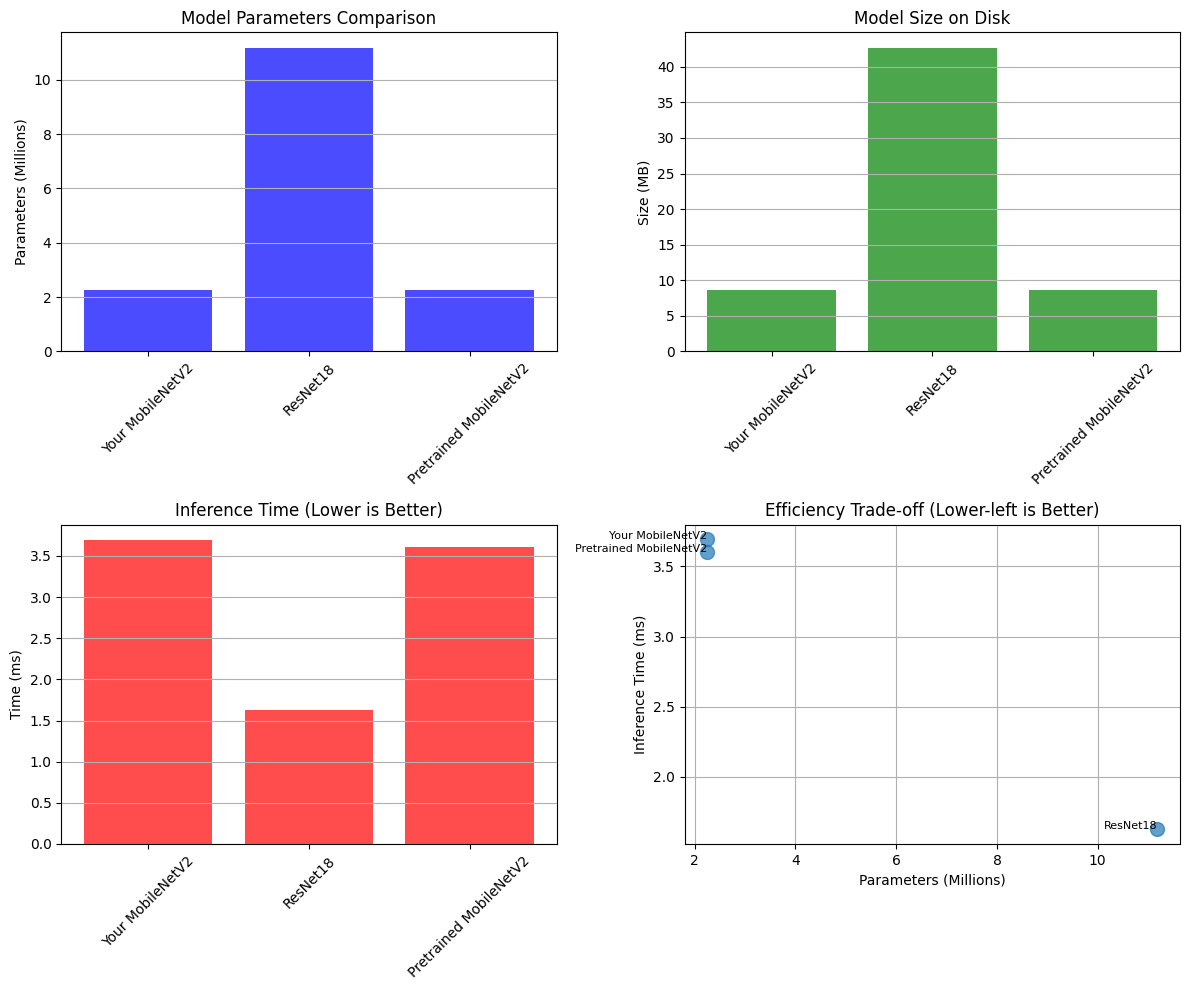


Training Your MobileNetV2


Do you want to train your MobileNetV2? (y/n):  y



Epoch 1/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:04<00:00, 19.64it/s]


Train Loss: 2.4091, Train Acc: 25.44%
Val Loss: 2.0228, Val Acc: 36.84%

Epoch 2/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:04<00:00, 18.98it/s]


Train Loss: 1.6199, Train Acc: 51.32%
Val Loss: 1.6490, Val Acc: 51.71%

Epoch 3/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:04<00:00, 19.16it/s]


Train Loss: 1.1663, Train Acc: 65.24%
Val Loss: 0.9847, Val Acc: 71.41%

Epoch 4/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:04<00:00, 19.18it/s]


Train Loss: 0.6601, Train Acc: 81.34%
Val Loss: 0.6736, Val Acc: 81.04%

Epoch 5/5
------------------------------


Evaluating: 100%|██████████| 90/90 [00:04<00:00, 19.68it/s]


Train Loss: 0.5429, Train Acc: 85.05%
Val Loss: 0.6106, Val Acc: 83.52%


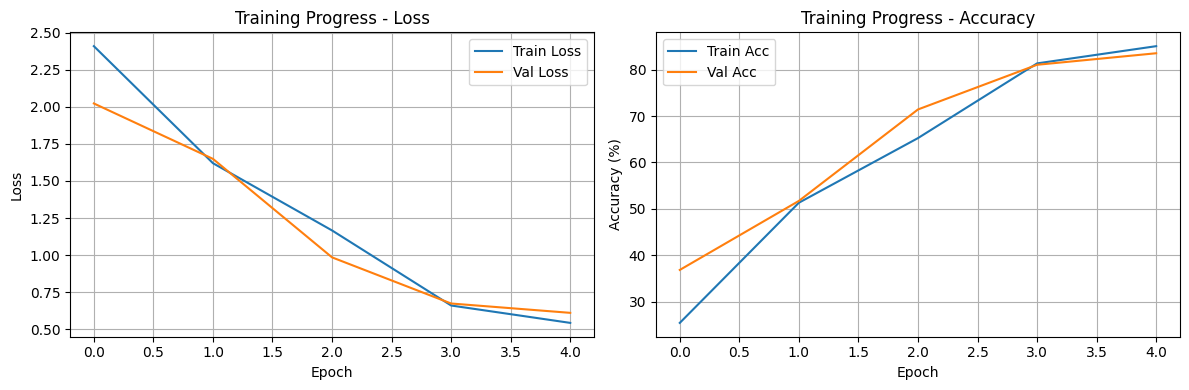


Final Validation Accuracy: 83.52%
✓ Great job! Your model achieves good accuracy while being efficient!

Assignment Complete!

Key Takeaways:
1. Depthwise separable convolutions reduce parameters by ~8-9x
2. Inverted residuals with linear bottlenecks preserve information
3. MobileNetV2 achieves ResNet-level accuracy with 10x fewer parameters
4. Efficient models are crucial for edge deployment (phones, IoT, etc.)


In [5]:
"""
Assignment Extension: Memory-Efficient Architectures for Edge Deployment
========================================================================
Learning Objectives:
1. Implement depthwise separable convolutions (MobileNet)
2. Build inverted residual blocks (MobileNetV2)
3. Understand FLOPs vs parameters vs memory trade-offs
4. Design models for memory-constrained devices

Total Points: 20
- Depthwise Separable Conv implementation (5 pts)
- Inverted Residual Block implementation (5 pts)
- MobileNetV2 architecture (5 pts)
- Model efficiency analysis (5 pts)

IMPORTANT CONCEPTS:
- FLOPs (Floating Point Operations): Measure of computational cost
  Standard Conv: FLOPs = 2 × H × W × K² × C_in × C_out
  Depthwise Conv: FLOPs = 2 × H × W × K² × C_in
  Pointwise Conv: FLOPs = 2 × H × W × C_in × C_out

- Parameters: Number of trainable weights
  Standard Conv: params = K² × C_in × C_out + C_out (bias)
  Depthwise: params = K² × C_in + C_in
  Pointwise: params = C_in × C_out + C_out

- Memory: Storage needed for model weights (typically 4 bytes per float32 param)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import zipfile
import urllib.request
from tqdm import tqdm
import time

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Download dataset function
def download_dataset():
    """Download and extract the UVA landmarks dataset."""
    url = "https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7"

    if not os.path.exists('dataset'):
        print("Downloading dataset...")
        urllib.request.urlretrieve(url, 'dataset.zip')
        print("Extracting dataset...")
        with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
            zip_ref.extractall('.')
        os.remove('dataset.zip')
    else:
        print("Dataset already exists.")

download_dataset()

# Dataset parameters
data_dir = "dataset/"
batch_size = 32
img_size = 224  # MobileNet/EfficientNet use 224x224
num_classes = 18

# Data transforms
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
full_dataset = datasets.ImageFolder(data_dir)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")



class ConvBNReLU(nn.Sequential):
    """
    The atomic unit of modern CNNs. This replaced Conv→ReLU after 2015.
    This is used EVERYWHERE - VGG, ResNet,
    MobileNet, EfficientNet. It's not just a pattern, it's THE pattern.
    """
    def __init__(self, c_in, c_out, kernel_size=3, stride=1, padding=1):
        super().__init__(
            # Key insight: bias=False because BN (batchnorm) learns bias
            # No forward method needed since the convolution2d to batchnorm to ReLU does it itself.
            nn.Conv2d(c_in, c_out, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True)  # inplace saves memory
        )

# ============================================================================
# Part 1: Depthwise Separable Convolution (5 points)
# ============================================================================

class DepthwiseSeparableConv(nn.Module):
    """
    TODO (5 pts): Implement depthwise separable convolution as used in MobileNet.

    This replaces a standard convolution with two operations:
    1. Depthwise convolution: Apply a single filter per input channel
    2. Pointwise convolution: 1x1 conv to combine channels

    Design Requirements:
    - Depthwise: Conv2d with groups=in_channels (each filter operates on one channel)
    - Pointwise: Conv2d with kernel_size=1 (combines information across channels)
    - Use BatchNorm2d after each convolution
    - Use ReLU6 activation (clamps output between 0 and 6, better for quantization)
    - No bias in conv layers when using BatchNorm (bias=False)

    Efficiency Analysis:
    - Standard 3x3 conv: 9 × C_in × C_out parameters
    - Depthwise + Pointwise: 9 × C_in + C_in × C_out parameters
    - Reduction factor: approximately 8-9x for typical channel counts

    Example: C_in=128, C_out=128
    - Standard: 9 × 128 × 128 = 147,456 params
    - DW+PW: 9 × 128 + 128 × 128 = 17,536 params (8.4x reduction!)
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        
        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, stride = stride, kernel_size = 3, padding = 1, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True)
        )
        
        # TODO: Implement depthwise convolution
        # Hint: Use groups=in_channels to make each filter operate on single channel
        # Structure: Conv2d -> BatchNorm2d -> ReLU6
        # Kernel size should be 3x3 with padding=1 to maintain spatial dimensions

        self.pointwise = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
        # TODO: Implement pointwise convolution
        # Hint: This is a 1x1 convolution that combines the depthwise outputs
        # Structure: Conv2d(kernel_size=1) -> BatchNorm2d -> ReLU6

        pass

    def forward(self, x):
        return self.pointwise(self.depthwise(x))
        
        # TODO: Apply depthwise then pointwise convolution
        # Return the final output
        pass

    
# ============================================================================
# Part 2: Inverted Residual Block (5 points)
# ============================================================================

class InvertedResidual(nn.Module):
    """
    TODO (5 pts): Implement the inverted residual block from MobileNetV2.

    Key Innovation: "Inverted" means we expand channels first, then compress
    Traditional residual: wide -> narrow -> wide
    Inverted residual: narrow -> wide -> narrow

    Architecture:
    1. Expansion layer: 1x1 conv to expand channels by expand_ratio
    2. Depthwise layer: 3x3 depthwise conv (may have stride for downsampling)
    3. Projection layer: 1x1 conv to project back to output channels
    4. Skip connection: Only when stride=1 AND in_channels=out_channels

    Design Requirements:
    - Expansion: Only if expand_ratio != 1 (skip if no expansion needed)
    - All layers use BatchNorm, but NO activation after final projection
    - Use ReLU6 for all activations except the last layer
    - hidden_dim = in_channels * expand_ratio

    Memory Optimization:
    - Linear bottleneck (no activation after projection) preserves information
    - Skip connection only when dimensions match (saves memory)

    FLOP Analysis for one block (H×W×C_in input):
    - Expansion: H×W×C_in×(expand_ratio×C_in) FLOPs
    - Depthwise: H×W×9×(expand_ratio×C_in) FLOPs
    - Projection: H×W×(expand_ratio×C_in)×C_out FLOPs
    """
    def __init__(self, in_channels, out_channels, stride=1, expand_ratio=6):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        hidden_dim = int(round(in_channels * expand_ratio))

        if (self.stride == 1) and (in_channels == out_channels):
            self.use_residual = True
        else:
            self.use_residual = False
        
        # TODO: Determine when to use residual connection
        # Residual only when: stride=1 AND in_channels=out_channels
        # Store as self.use_residual
        
        layers = []
        if expand_ratio != 1:
            layers.append(ConvBNReLU(in_channels, hidden_dim, kernel_size = 1, padding = 0)) #drop padding to maintain dimensions
            
        layers.append(nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, 
                                stride=self.stride, padding=1, groups=hidden_dim, bias = False))  
        layers.append(nn.BatchNorm2d(hidden_dim))
        layers.append(nn.ReLU6(inplace=True))
        
        layers.append(nn.Conv2d(hidden_dim, out_channels, kernel_size = 1, bias = False))
        layers.append(nn.BatchNorm2d(out_channels))
                          
        # TODO: Build the layers list
        # If expand_ratio != 1:
        #   Add expansion layer: Conv2d(kernel=1) -> BN -> ReLU6
        # Always add:
        #   Depthwise: Conv2d(kernel=3, stride=stride, groups=hidden_dim) -> BN -> ReLU6
        #   Projection: Conv2d(kernel=1) -> BN (NO activation here!)

        self.conv = nn.Sequential(*layers)
        
        # TODO: Combine layers into self.conv = nn.Sequential(*layers)
        pass

    def forward(self, x):
        out = self.conv(x)
        if self.use_residual == True:
            return x + out
        else:
            return out
                          
        # TODO: Implement forward pass
        # If self.use_residual is True: return x + self.conv(x)
        # Otherwise: return self.conv(x)
        pass


# ============================================================================
# Part 3: MobileNetV2 Architecture (5 points)
# ============================================================================

class MobileNetV2(nn.Module):
    """
    TODO (5 pts): Build a simplified MobileNetV2 architecture.

    Architecture Overview:
    1. Initial conv: 3 -> 32 channels, stride=2 (downsample to 112x112)
    2. Series of InvertedResidual blocks with specific configurations
    3. Final conv: expand to 1280 channels (wide feature layer)
    4. Global average pooling
    5. Classifier: Linear(1280, num_classes)

    Block Configuration:
    Each block has (in_channels, out_channels, stride, expand_ratio)
    - t=1: no expansion, t=6: 6x expansion
    - s=2: downsample spatial dimensions by 2

    Design Principles:
    - Width multiplier: Can scale all channels by a factor (0.5, 0.75, 1.0)
    - Resolution multiplier: Can use smaller input sizes (192, 160, 128)

    Memory Considerations:
    - Peak memory usage occurs at expansion layers
    - Skip connections don't add parameters but need memory for gradients
    - Total params ≈ 2.3M for width_mult=1.0 (vs ResNet50's 25M)

    Suggested Block Sequence (simplified):
    Stage 1: 32 -> 16, t=1, s=1
    Stage 2: 16 -> 24, t=6, s=2 (downsample)
             24 -> 24, t=6, s=1
    Stage 3: 24 -> 32, t=6, s=2 (downsample)
             32 -> 32, t=6, s=1 (repeat 2x)
    Stage 4: 32 -> 64, t=6, s=2 (downsample)
             64 -> 64, t=6, s=1 (repeat 3x)
    Stage 5: 64 -> 96, t=6, s=1 (repeat 3x)
    Stage 6: 96 -> 160, t=6, s=2 (downsample)
             160 -> 160, t=6, s=1 (repeat 2x)
    Stage 7: 160 -> 320, t=6, s=1
    """
    def __init__(self, num_classes=18, width_mult=1.0, dropout_prob=0.2):
        super(MobileNetV2, self).__init__()
        self.conv1 = ConvBNReLU(3, 32, kernel_size = 3, stride = 2, padding = 1)
                          
        # TODO: Build the initial convolution layer
        # Conv2d(3, 32, kernel=3, stride=2, padding=1) -> BN -> ReLU6
        # This reduces 224x224 to 112x112
        
        self.residualblock = nn.Sequential(
            # Stage 1: 32 -> 16, t=1, s=1 (no expansion, no downsample)
            self._make_stage(int(round(32 * width_mult)), int(round(16 * width_mult)), num_blocks=1, stride=1, expand_ratio=1),
            
            # Stage 2: 16 -> 24, downsample, then repeat
            self._make_stage(int(round(16 * width_mult)), int(round(24 * width_mult)), num_blocks=2, stride=2, expand_ratio=6),
            
            # Stage 3: 24 -> 32, downsample, then repeat 2x more (3 total)
            self._make_stage(int(round(24 * width_mult)), int(round(32 * width_mult)), num_blocks=3, stride=2, expand_ratio=6),
            
            # Stage 4: 32 -> 64, downsample, then repeat 3x more (4 total)
            self._make_stage(int(round(32 * width_mult)), int(round(64 * width_mult)), num_blocks=4, stride=2, expand_ratio=6),
            
            # Stage 5: 64 -> 96, no downsample with stride 1 for all, repeat 3x (3 total)
            self._make_stage(int(round(64 * width_mult)), int(round(96 * width_mult)), num_blocks=3, stride=1, expand_ratio=6),
            
            # Stage 6: 96 -> 160, downsample, then repeat 2x more (3 total)
            self._make_stage(int(round(96 * width_mult)), int(round(160 * width_mult)), num_blocks=3, stride=2, expand_ratio=6),
            
            # Stage 7: 160 -> 320, no downsample, single block
            self._make_stage(int(round(160 * width_mult)), int(round(320 * width_mult)), num_blocks=1, stride=1, expand_ratio=6)
        )
        
                                  
        # TODO: Build the InvertedResidual blocks
        # Create a nn.Sequential with all the blocks following the configuration above
        # Remember to apply width_mult to scale channel counts if needed

        self.conv2 = ConvBNReLU(int(round(320 * width_mult)), int(round(1280 * width_mult)), kernel_size = 1)
        
        # TODO: Build the final convolution layer
        # Conv2d(320, 1280, kernel=1) -> BN -> ReLU6
        # This creates a wide feature layer for better classification
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
                          
        # TODO: Add global average pooling
        # Use nn.AdaptiveAvgPool2d((1, 1)) to handle any input size
                          
        self.dropout = nn.Dropout(p = dropout_prob)
                          
        # TODO: Add dropout for regularization (optional but recommended)
        # nn.Dropout(p=dropout_prob) before the classifier
        last_channel = int(round(1280 * width_mult))
        self.fc = nn.Linear(last_channel, num_classes)
                          
        # TODO: Add the final classifier
        # nn.Linear(1280, num_classes)
                          
        self._initialize_weights()

        # TODO: Initialize weights properly
        # Call self._initialize_weights()
        pass

    def _make_stage(self, in_channels, out_channels, num_blocks, stride, expand_ratio):
        """
        Helper function to create a stage with multiple inverted residual blocks.
        """
        #Ensuring the in and out channels are ints
        in_channels = int(round(in_channels))
        out_channels = int(round(out_channels))
        # Create empty list to store all blocks
        blocks = []
        # Loop through and create each block
        for i in range(num_blocks):
            # Determine if this is the first block
            if i == 0:
                # First block: uses the given stride (may downsample)
                # Input channels = in_channels, output channels = out_channels
                blocks.append(InvertedResidual(in_channels=in_channels, out_channels=out_channels, 
                                   stride=stride, expand_ratio=expand_ratio))
            else:
                # Subsequent blocks: stride=1 (no downsampling)
                # Input channels = output channels (dimensions already match)
                # This enables residual connections for all subsequent blocks
                blocks.append(InvertedResidual(in_channels=out_channels, out_channels=out_channels, 
                                   stride=1, expand_ratio=expand_ratio))
        
        return nn.Sequential(*blocks)


    def forward(self, x):
        x = self.conv1(x)
        x = self.residualblock(x)
        x = self.conv2(x)
        x = self.avgpool(x).flatten(start_dim=1)
        x = self.dropout(x)
        return self.fc(x)
                          
        # TODO: Implement the forward pass
        # Pass through: features -> avgpool -> flatten -> dropout -> classifier
        pass

    def _initialize_weights(self):
        """Initialize model weights for better training."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)


# ============================================================================
# Part 4: Model Efficiency Analysis (5 points)
# ============================================================================

def count_parameters(model):
    """Count total and trainable parameters."""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

def get_model_size_mb(model):
    """Calculate model size in MB (assuming float32 weights)."""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()

    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / (1024 ** 2)
    return size_all_mb

def estimate_flops(model, input_shape=(1, 3, 224, 224)):
    """
    TODO (Bonus): Estimate FLOPs for your model.

    Simplified FLOP counting:
    - Conv2d: 2 × H_out × W_out × K² × C_in × C_out / groups
    - Linear: 2 × in_features × out_features
    - BatchNorm: 4 × num_features (can often ignore)

    This is complex to implement fully, so a simplified version is fine.
    You can also use existing libraries like thop or ptflops if available.
    """
    # Optional implementation
    total_flops = 0
    # Hint: You'd need to track input/output shapes through the network
                                    
    try:
        from thop import profile
        import torch
        
        # # Create dummy input testing
        # dummy_input = torch.randn(input_shape)
        
        # Calculate FLOPs
        total_flops, params = profile(model, inputs=(input_shape,), verbose=False)
        
        print(f"FLOPs: {flops/1e9:.2f} GFLOPs")
        print(f"Params: {params/1e6:.2f} M")
        
        return total_flops
        
    except ImportError:
        print("Install thop: pip install thop")
        return 0
                          

def measure_inference_time(model, input_shape=(1, 3, 224, 224), num_runs=100):
    """Measure average inference time in milliseconds."""
    model.eval()
    device = next(model.parameters()).device
    dummy_input = torch.randn(input_shape).to(device)

    # Warm up (important for accurate timing)
    for _ in range(10):
        with torch.no_grad():
            _ = model(dummy_input)

    # Synchronize if using CUDA
    if torch.cuda.is_available():
        torch.cuda.synchronize()

    # Time the inference
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(dummy_input)

    if torch.cuda.is_available():
        torch.cuda.synchronize()

    end_time = time.time()
    avg_time = (end_time - start_time) / num_runs * 1000  # Convert to ms
    return avg_time

# ============================================================================
# Training Functions (Provided - No TODO)
# ============================================================================

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': running_loss / (progress_bar.n + 1),
            'acc': 100. * correct / total
        })

    return running_loss / len(dataloader), 100. * correct / total

def evaluate(model, dataloader, criterion, device):
    """Evaluate model on validation/test set."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(dataloader), 100. * correct / total

# ============================================================================
# Visualization Functions (Provided - No TODO)
# ============================================================================

def plot_model_comparison(models_dict):
    """Compare efficiency metrics of different models."""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    model_names = list(models_dict.keys())
    params_list = []
    size_list = []
    time_list = []

    for name, model in models_dict.items():
        total_params, _ = count_parameters(model)
        params_list.append(total_params / 1e6)  # Convert to millions
        size_list.append(get_model_size_mb(model))
        time_list.append(measure_inference_time(model.to(device)))

    # Plot 1: Parameters
    axes[0, 0].bar(model_names, params_list, color='blue', alpha=0.7)
    axes[0, 0].set_ylabel('Parameters (Millions)')
    axes[0, 0].set_title('Model Parameters Comparison')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, axis='y')

    # Plot 2: Model Size
    axes[0, 1].bar(model_names, size_list, color='green', alpha=0.7)
    axes[0, 1].set_ylabel('Size (MB)')
    axes[0, 1].set_title('Model Size on Disk')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, axis='y')

    # Plot 3: Inference Time
    axes[1, 0].bar(model_names, time_list, color='red', alpha=0.7)
    axes[1, 0].set_ylabel('Time (ms)')
    axes[1, 0].set_title('Inference Time (Lower is Better)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, axis='y')

    # Plot 4: Efficiency Score
    axes[1, 1].scatter(params_list, time_list, s=100, alpha=0.7)
    for i, name in enumerate(model_names):
        axes[1, 1].annotate(name, (params_list[i], time_list[i]),
                           fontsize=8, ha='right')
    axes[1, 1].set_xlabel('Parameters (Millions)')
    axes[1, 1].set_ylabel('Inference Time (ms)')
    axes[1, 1].set_title('Efficiency Trade-off (Lower-left is Better)')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

def plot_training_curves(history):
    """Plot training and validation curves."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Loss curves
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Progress - Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy curves
    axes[1].plot(history['train_acc'], label='Train Acc')
    axes[1].plot(history['val_acc'], label='Val Acc')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training Progress - Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# ============================================================================
# Main Execution - Test Your Implementation
# ============================================================================

if __name__ == "__main__":
    print("="*80)
    print("Testing Your Efficient Architecture Implementation")
    print("="*80)

    # Test your implementations
    try:
        # Test DepthwiseSeparableConv
        print("\n1. Testing DepthwiseSeparableConv...")
        dw_conv = DepthwiseSeparableConv(32, 64)
        test_input = torch.randn(1, 32, 56, 56)
        output = dw_conv(test_input)
        print(f"   Input shape: {test_input.shape}")
        print(f"   Output shape: {output.shape}")
        print(f"   ✓ DepthwiseSeparableConv working!")
    except Exception as e:
        print(f"   ✗ Error in DepthwiseSeparableConv: {e}")

    try:
        # Test InvertedResidual
        print("\n2. Testing InvertedResidual...")
        inv_res = InvertedResidual(32, 32, stride=1, expand_ratio=6)
        test_input = torch.randn(1, 32, 56, 56)
        output = inv_res(test_input)
        print(f"   Input shape: {test_input.shape}")
        print(f"   Output shape: {output.shape}")
        print(f"   ✓ InvertedResidual working!")
    except Exception as e:
        print(f"   ✗ Error in InvertedResidual: {e}")

    try:
        # Test MobileNetV2
        print("\n3. Testing MobileNetV2...")
        mobilenet = MobileNetV2(num_classes=num_classes)
        test_input = torch.randn(1, 3, 224, 224)
        output = mobilenet(test_input)
        print(f"   Input shape: {test_input.shape}")
        print(f"   Output shape: {output.shape}")

        # Analyze model
        total_params, trainable_params = count_parameters(mobilenet)
        model_size = get_model_size_mb(mobilenet)
        print(f"   Total parameters: {total_params:,}")
        print(f"   Trainable parameters: {trainable_params:,}")
        print(f"   Model size: {model_size:.2f} MB")
        print(f"   ✓ MobileNetV2 working!")

    except Exception as e:
        print(f"   ✗ Error in MobileNetV2: {e}")

    # Compare with other models
    print("\n" + "="*80)
    print("Model Comparison")
    print("="*80)

    try:
        # Create models for comparison
        models_to_compare = {
            'Your MobileNetV2': MobileNetV2(num_classes=num_classes),
            'ResNet18': models.resnet18(num_classes=num_classes),
            'Pretrained MobileNetV2': models.mobilenet_v2(weights=None, num_classes=num_classes)
        }

        # Compare models
        for name, model in models_to_compare.items():
            total_params, _ = count_parameters(model)
            size_mb = get_model_size_mb(model)
            print(f"{name:20s}: {total_params/1e6:.2f}M params, {size_mb:.2f} MB")

        # Visualize comparison
        plot_model_comparison(models_to_compare)

    except Exception as e:
        print(f"Error in model comparison: {e}")

    # Train your model (optional - takes time)
    print("\n" + "="*80)
    print("Training Your MobileNetV2")
    print("="*80)

    train_model = input("Do you want to train your MobileNetV2? (y/n): ")

    if train_model.lower() == 'y':
        try:
            model = MobileNetV2(num_classes=num_classes, dropout_prob=0.2)
            model = model.to(device)

            # Setup training
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

            # Training loop
            num_epochs = 5
            history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

            for epoch in range(num_epochs):
                print(f"\nEpoch {epoch+1}/{num_epochs}")
                print("-" * 30)

                train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
                val_loss, val_acc = evaluate(model, val_loader, criterion, device)

                history['train_loss'].append(train_loss)
                history['train_acc'].append(train_acc)
                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)

                print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
                print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

                scheduler.step()

            # Plot training curves
            plot_training_curves(history)

            print(f"\nFinal Validation Accuracy: {history['val_acc'][-1]:.2f}%")

            # Success criteria
            if history['val_acc'][-1] > 80:
                print("✓ Great job! Your model achieves good accuracy while being efficient!")
            elif history['val_acc'][-1] > 70:
                print("✓ Good start! Try fine-tuning hyperparameters or training longer.")
            else:
                print("Keep working! Check your implementation and try different settings.")

        except Exception as e:
            print(f"Error during training: {e}")

    print("\n" + "="*80)
    print("Assignment Complete!")
    print("="*80)
    print("\nKey Takeaways:")
    print("1. Depthwise separable convolutions reduce parameters by ~8-9x")
    print("2. Inverted residuals with linear bottlenecks preserve information")
    print("3. MobileNetV2 achieves ResNet-level accuracy with 10x fewer parameters")
    print("4. Efficient models are crucial for edge deployment (phones, IoT, etc.)")
    print("="*80)

## QUESTION FROM CLASS - 



In [ ]:
"""
Dataset: UVA Landmarks with 18 classes
Submission: yourcomputingID_assignment_2.ipynb and pdf

IMPORTANT DESIGN PRINCIPLES:
1. Use BatchNorm after every Conv layer (before activation)
2. Use ReLU activation (inplace=True saves memory)
3. Use bias=False in Conv when followed by BatchNorm
4. Initialize weights properly for better convergence
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import zipfile
import urllib.request
from tqdm import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# ============================================================================
# Data Loading and Preprocessing
# ============================================================================

def download_dataset():
    """Download and extract the UVA landmarks dataset."""
    url = "https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7"

    if not os.path.exists('dataset'):
        print("Downloading dataset...")
        urllib.request.urlretrieve(url, 'dataset.zip')
        print("Extracting dataset...")
        with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
            zip_ref.extractall('.')
        os.remove('dataset.zip')
    else:
        print("Dataset already exists.")

# Download dataset
download_dataset()

# Dataset parameters
data_dir = "dataset/"
batch_size = 32
img_height = 150
img_width = 150
num_classes = 18

# Class names for UVA landmarks
class_names = ['AcademicalVillage', 'AldermanLibrary', 'AlumniHall', 'AquaticFitnessCenter',
               'BavaroHall', 'BrooksHall', 'ClarkHall', 'MadisonHall', 'MinorHall',
               'NewCabellHall', 'NewcombHall', 'OldCabellHall', 'OlssonHall', 'RiceHall',
               'Rotunda', 'ScottStadium', 'ThorntonHall', 'UniversityChapel']

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
full_dataset = datasets.ImageFolder(data_dir)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Apply transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


In [ ]:
class BasicBlock(nn.Module):
    """
    ResNet Basic Block - the building block of ResNet-18/34

    CRITICAL DESIGN CHOICES (explain each):
    1. Two 3×3 convs (following VGG principle)
    2. Skip connection bypasses both convs
    3. ReLU AFTER addition (not before)
    4. Projection when dimensions don't match
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = ConvBNReLU(in_channels, out_channels, kernel_size = 3) # bias preset to False, padding set to 1
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)            
        )
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride = stride, bias=False),
                nn.BatchNorm2d(out_channels)                     
            )
            
        pass

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv2(self.conv1(x))
        out = out + identity
        return F.relu(out, inplace = True)

        pass


In [ ]:
# MBConv Block (Mobile Inverted Bottleneck Convolution)
class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio=0.25):
        super(MBConvBlock, self).__init__()
        self.stride = stride
        self.use_residual = (stride == 1 and in_channels == out_channels)
        
        # Expansion phase
        hidden_dim = in_channels * expand_ratio
        self.use_expansion = expand_ratio != 1
        
        if self.use_expansion:
            self.expand_conv = nn.Conv2d(in_channels, hidden_dim, 1, bias=False)
            self.expand_bn = nn.BatchNorm2d(hidden_dim)
        
        # Depthwise convolution
        padding = (kernel_size - 1) // 2
        self.depthwise_conv = nn.Conv2d(
            hidden_dim, hidden_dim, kernel_size,
            stride=stride, padding=padding, groups=hidden_dim, bias=False
        )
        self.depthwise_bn = nn.BatchNorm2d(hidden_dim)
        
        # Note: EfficientNet-Lite doesn't use Squeeze-and-Excitation layers
        # This is one of the main differences from standard EfficientNet
        
        # Output projection
        self.project_conv = nn.Conv2d(hidden_dim, out_channels, 1, bias=False)
        self.project_bn = nn.BatchNorm2d(out_channels)

In [ ]:
class ResNetMini(nn.Module):
    """Tiny ResNet with staged blocks"""
    def __init__(self, num_classes=10):
        super().__init__()
        self.stem = ConvBNReLU(1, 32, kernel_size=3, padding=1)

        # Staged design (like real ResNet)
        self.layer1 = nn.Sequential(
            BasicBlock(32, 32),
            BasicBlock(32, 32)
        )
        self.layer2 = nn.Sequential(
            BasicBlock(32, 64, stride=2),    # Downsample
            BasicBlock(64, 64)
        )
        self.layer3 = BasicBlock(64, 128, stride=2)  # Downsample

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.gap(x).flatten(1)
        return self.fc(x)

